In [1]:
import sklearn.datasets as skdata
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import sklearn.cluster as cluster
import sklearn.model_selection as selection
import sklearn.metrics as metrics
import numpy as np
from numpy.typing import NDArray
import random
from typing import *

# Задание 1

In [2]:
data_1 = skdata.make_blobs(25, 2, centers=2, cluster_std=0.8, random_state=14)
data_2 = skdata.make_blobs(100, 2, centers=3, cluster_std=1, random_state=14)
data_3 = skdata.make_blobs(350, 2, centers=4, cluster_std=1.35, random_state=14)
blobs_list: tuple[tuple[NDArray, NDArray]] = (data_1, data_2, data_3)

# Задание 2

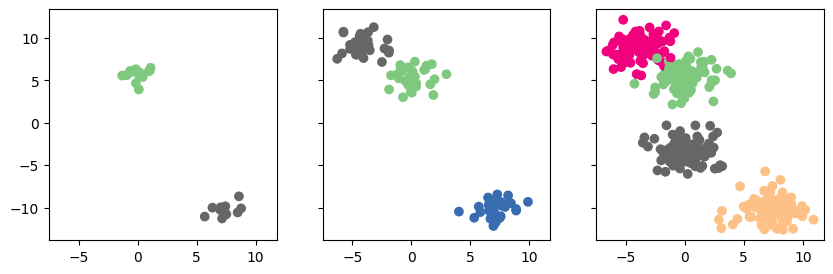

In [3]:
figure, _ = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))
for data, axis in zip(blobs_list, figure.axes):
    axis.scatter(data[0][:, 0], data[0][:, 1], c=data[1], cmap="Accent")

plt.show()

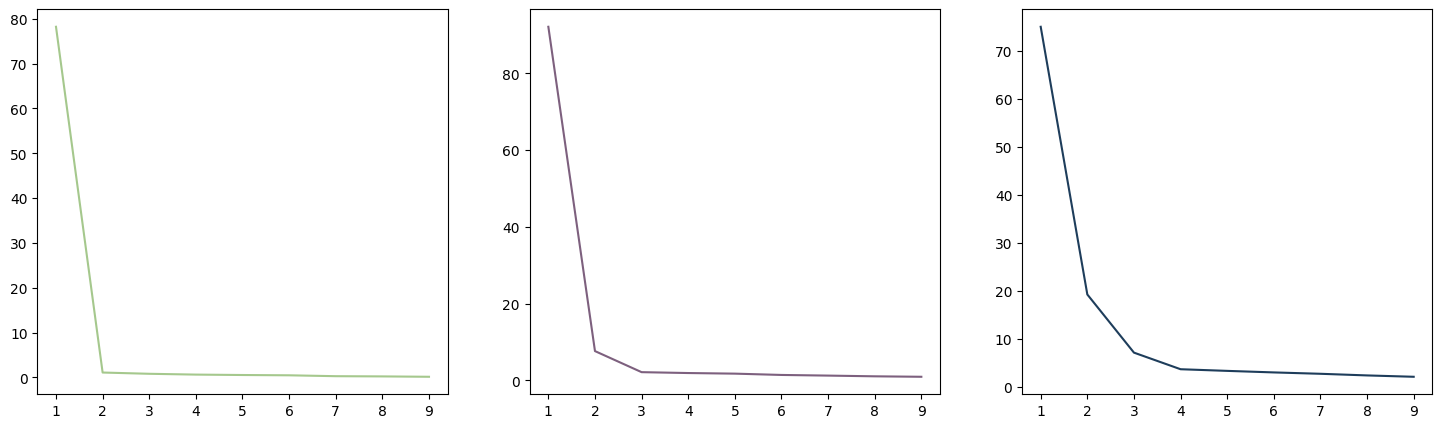

In [4]:
results_list: list[dict[int, float]] = list()

for i, data in enumerate(blobs_list):
    parameters_grid = selection.ParameterGrid({"n_clusters": np.arange(1, 10)})
    results_list.append(dict())
    results = results_list[-1]
    for params in parameters_grid:
        model = cluster.KMeans(n_init="auto", **params).fit(data[0])
        internal_cluster_distance_sum: float
        prediction = model.predict(data[0])
        centroids_per_object: list[NDArray] = [model.cluster_centers_[class_] for class_ in prediction]
        score: float = np.power(metrics.pairwise.paired_euclidean_distances(data[0], centroids_per_object), 2).mean()
        results.update({params.get("n_clusters"): score})


figure, _ = plt.subplots(1, 3, figsize=(18, 5))
for data, axis, results in zip(blobs_list, figure.axes, results_list):
    axis.plot(results.keys(), results.values(), color=[random.randint(20, 200) / 255 for _ in range(3)])

plt.show()

По графикам зависимости суммы квадратов расстояний до центроидов от количества кластеров:

1: 2 кластера

2: 2 кластера (или 3)

3: 3 кластера (или 4)

In [5]:
models: list[cluster.KMeans] = list()
predictions: list[NDArray] = list()
for i, data in enumerate(blobs_list, start=1):
    parameters_grid = selection.ParameterGrid({"n_clusters": np.arange(2, 10)})
    best_model: cluster.KMeans = None
    best_score: float = None
    best_prediction: NDArray = None
    for params in parameters_grid:
        model = cluster.KMeans(n_init="auto", **params).fit(data[0])
        internal_cluster_distance_sum: float
        prediction = model.predict(data[0])
        centroids_per_object: list[NDArray] = [model.cluster_centers_[class_] for class_ in prediction]
        score = metrics.silhouette_score(data[0], prediction)
        if best_score == None or score > best_score:
            best_model, best_score, best_prediction = model, score, prediction
    models.append(best_model)
    predictions.append(best_prediction)
    print(f"{i}: {best_model.get_params()['n_clusters']} clusters, score: {best_score}")

1: 2 clusters, score: 0.9226202594578196
2: 2 clusters, score: 0.8320871671643647
3: 3 clusters, score: 0.6719540560148428


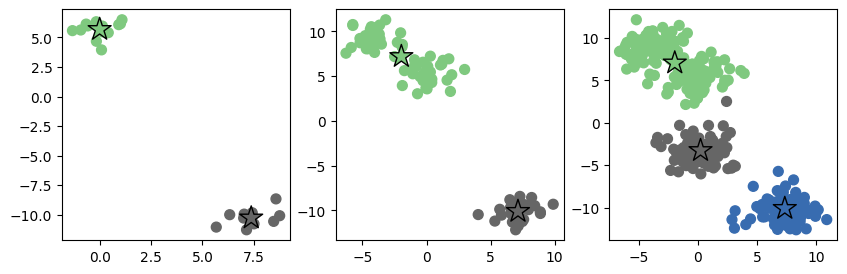

In [6]:
figure, _ = plt.subplots(1, 3, figsize=(10, 3))
for data, prediction, model, axis in zip(blobs_list, predictions, models, figure.axes, strict=True):
    axis.scatter(data[0][:, 0], data[0][:, 1], s=50, c=prediction, cmap="Accent")
    axis.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, cmap="Accent", marker="*", edgecolors="black", c=range(model.cluster_centers_.shape[0]))

1: {'eps': 1.5000000000000002, 'min_samples': 2}, score: 0.9226202594578196
2: {'eps': 1.6, 'min_samples': 2}, score: 0.8320871671643647
3: {'eps': 1.9000000000000001, 'min_samples': 2}, score: 0.6731934704743222


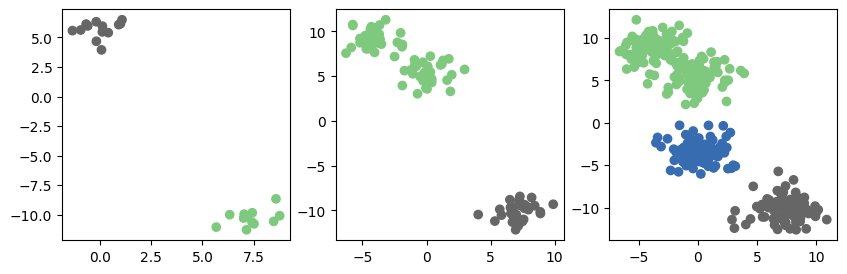

In [7]:
predictions: list[NDArray] = list()
for i, data in enumerate(blobs_list, start=1):
    parameters_grid = selection.ParameterGrid({"eps": np.arange(0.1, 3, 0.1), "min_samples": np.arange(2, 50, 2)})
    best_score: float = None
    best_params: dict[str, Any] = None
    best_prediction: NDArray = None
    for params in parameters_grid:
        model = cluster.DBSCAN(**params)
        prediction = model.fit_predict(data[0])
        if np.unique(prediction).shape[0] < 2:
            continue
        score = metrics.silhouette_score(data[0], prediction)
        if best_score == None or score > best_score:
            best_params, best_score, best_prediction = params, score, prediction
    predictions.append(best_prediction)
    print(f"{i}: {best_params}, score: {best_score}")

figure, _ = plt.subplots(1, 3, figsize=(10, 3))
for data, prediction, axis in zip(blobs_list, predictions, figure.axes, strict=True):
    axis.scatter(data[0][:, 0], data[0][:, 1], c=prediction, cmap="Accent")

# Задание 3

In [8]:
from typing_extensions import Self

class KMeans:
    def __init__(self, clusters: int, initial_cluster_distribution=5, eps=1e-5) -> None:
        self._clusters = clusters
        self.centers: NDArray = None
        self._dimentions: int = None
        self._labels: NDArray | None = None
        self._stop_condition: bool
        self.X: NDArray = None
        self._eps = eps
        self._initial_cluster_distribution = initial_cluster_distribution

    def _euclidean_distance(self, point1: NDArray, point2: NDArray) -> float:
        return np.sqrt(np.sum((point1 - point2)**2))
    
    def _update_labels(self) -> None:
        labels = self.predict(self.X)
        self._labels = labels
    
    def _get_label(self, point: NDArray) -> int:
        return np.argmin(self._euclidean_distance(self.centers, point))

    def _get_centers_max_difference(self, centers: NDArray) -> float:
        return np.max([self._euclidean_distance(*pair) for pair in zip(self.centers, centers)])
    
    def _update_centers(self) -> None:
        new_centers = np.empty_like(self.centers)
        for i, center in enumerate(self.centers):
            cluster_points: NDArray = self.X[self._labels == i]
            new_centers[i] = np.mean(cluster_points, axis=0) if cluster_points.shape[0] > 0 else center
        if self._get_centers_max_difference(new_centers) < self._eps:
            self._stop_condition = True
        self.centers = new_centers
    
    def fit(self, X: NDArray, max_iterations: int = 100) -> Self:
        self.X = X
        self._stop_condition = False
        self._dimentions = X.shape[1]
        self.centers = np.random.uniform(-self._initial_cluster_distribution, self._initial_cluster_distribution, size=(self._clusters, self._dimentions))
        self._update_labels()
        i = 0
        while not self._stop_condition:
            self._update_centers()
            self._update_labels()
            i += 1
            if i >= max_iterations:
                self._stop_condition = True
        return self
    
    def predict(self, X: Optional[NDArray] = None) -> NDArray:
        if X is None:
            return self.labels
        prediction = np.apply_along_axis(lambda point: np.argmin([self._euclidean_distance(center, point) for center in self.centers]), axis=1, arr=self.X)
        return prediction
    
    @property
    def centroid_mean_square_distance(self) -> float:
        return np.power(np.apply_along_axis(lambda point: np.min([self._euclidean_distance(center, point) for center in self.centers]), axis=1, arr=self.X), 2).mean()
    
    @property
    def labels(self) -> NDArray:
        return self._labels
    
    @property
    def clusters(self) -> int:
        return self._clusters

1: 2 clusters, score: 0.9226202594578196
2: 2 clusters, score: 0.8320871671643647
3: 3 clusters, score: 0.6719540560148428


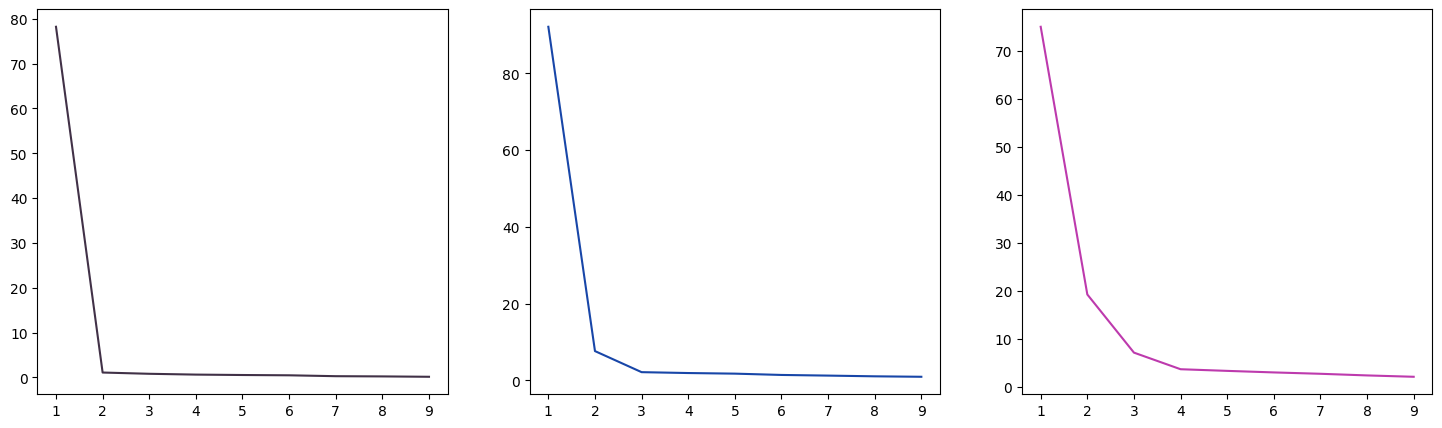

In [9]:
models: list[KMeans] = list()
predictions: list[NDArray] = list()
for i, data in enumerate(blobs_list, start=1):
    parameters_grid = selection.ParameterGrid({"clusters": np.arange(2, 10)})
    results_list.append(dict())
    results = results_list[-1]
    best_model: KMeans = None
    best_score: float = None
    best_prediction: NDArray = None
    for params in parameters_grid:
        model = KMeans(**params).fit(data[0])
        internal_cluster_distance_sum: float
        prediction = model.predict(data[0])
        score = metrics.silhouette_score(data[0], prediction)
        results.update({params.get("n_clusters"): model.centroid_mean_square_distance})
        if best_score == None or score > best_score:
            best_model, best_score, best_prediction = model, score, prediction
    models.append(best_model)
    predictions.append(best_prediction)
    print(f"{i}: {best_model.clusters} clusters, score: {best_score}")

figure, _ = plt.subplots(1, 3, figsize=(18, 5))
for data, axis, results in zip(blobs_list, figure.axes, results_list):
    axis.plot(results.keys(), results.values(), color=[random.randint(20, 200) / 255 for _ in range(3)])

plt.show()

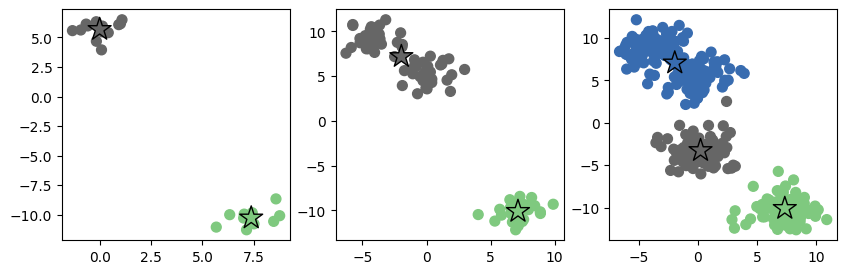

In [10]:
figure, _ = plt.subplots(1, 3, figsize=(10, 3))
for data, prediction, model, axis in zip(blobs_list, predictions, models, figure.axes, strict=True):
    axis.scatter(data[0][:, 0], data[0][:, 1], s=50, c=prediction, cmap="Accent")
    axis.scatter(model.centers[:, 0], model.centers[:, 1], s=300, cmap="Accent", marker="*", edgecolors="black", c=range(model.centers.shape[0]))

In [46]:
from collections import deque


class DBScan:
    _NOISE: Final[Literal[-1]] = -1

    def __init__(self, eps=1, min_samples=4) -> None:
        self._eps = eps
        self._min_samples = min_samples
        self._labels: NDArray
    
    def _euclidean_distance(self, point1: NDArray, point2: NDArray) -> float:
        return np.sqrt(np.sum((point1 - point2)**2))
    
    def _get_neighbors(self, point: NDArray, X: NDArray, labels: NDArray) -> deque[int]:
        a = np.apply_along_axis(lambda x: self._euclidean_distance(x, point), axis=1, arr=X)
        return deque(np.argwhere(a < self._eps).flatten())
    
    def fit(self, X: NDArray) -> Self:
        labels = np.full((X.shape[0], 1), None)
        current_label = -1
        for i, point in enumerate(X):
            if labels[i][0] is not None:
                continue
            neighbors: deque[int] = self._get_neighbors(point, X, labels)
            if len(neighbors) < self._min_samples:
                labels[i] = self._NOISE
                continue
            current_label += 1
            labels[i] = current_label
            while len(neighbors):
                neighbor_i = neighbors.popleft()
                if labels[neighbor_i][0] == self._NOISE:
                    labels[neighbor_i] = current_label
                elif labels[neighbor_i][0] is None:
                    labels[neighbor_i] = current_label
                    next_neighbors: deque[int] = self._get_neighbors(point, X, labels)
                    if len(next_neighbors) >= self._min_samples:
                        next_neighbors.extend(set(next_neighbors).difference(neighbors))
        self._labels = labels    
        return self
    
    def predict(self) -> NDArray:
        return self._labels


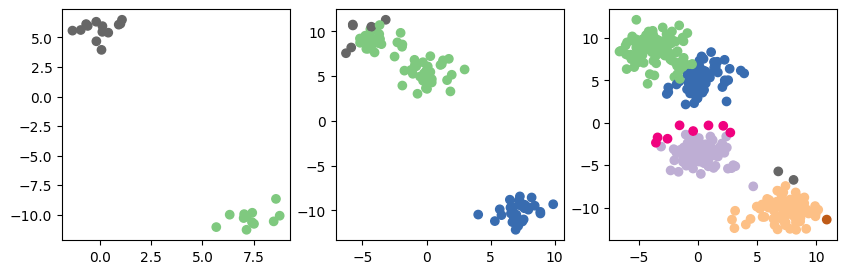

In [61]:
predictions: list[NDArray] = list()
for i, data in enumerate(blobs_list, start=1):
    prediction = DBScan(5).fit(data[0]).predict()
    predictions.append(prediction)

figure, _ = plt.subplots(1, 3, figsize=(10, 3))
for data, prediction, axis in zip(blobs_list, predictions, figure.axes, strict=True):
    axis.scatter(data[0][:, 0], data[0][:, 1], c=prediction, cmap="Accent")